In [1]:
import torch

### Load Analyzed Games

In [2]:
dataset = torch.load("../datasets/all_games_analyzed.pt")

In [3]:
# dataset is of the form [(white_analysis, black_analysis), (white_elo, black_elo)]
print(f"Number of games: {len(dataset)}")
print(f"Moves of first game: {len(dataset[0][0][0])}")
print(f"Input size: {len(dataset[0][0][0][0])}")

input_size = len(dataset[0][0][0][0])

Number of games: 2000
Moves of first game: 14
Input size: 771


### Define the Model

In [4]:
from lstm_network import initialize_model

In [5]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")          # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu") 

Using GPU: NVIDIA GeForce MX230


In [6]:
hidden_size = 128
num_layers = 2
lstm_model, optimizer = initialize_model(input_size, hidden_size, num_layers, device, num_classes=10)

### Modify the dataset for training

In [7]:
# These are the rating ranges the model will try to classify
rating_ranges = [
    (400, 900),
    (900, 1100),
    (1100, 1300),
    (1300, 1500),
    (1500, 1700),
    (1700, 1900),
    (1900, 2100),
    (2100, 2300),
    (2300, 2500),
    (2500, 3000),
]

# Suppose the elo of a player is a normal distribution with mean = elo and stdv = 100
# calculate the probability of the player being in each range by integrating the normal distribution in that range
def calculate_elo_range(elo):
    import scipy.stats as st

    stdv = 100
    return torch.tensor([
            st.norm.cdf(r[1], loc=elo, scale=stdv)
            - st.norm.cdf(r[0], loc=elo, scale=stdv)
            for r in rating_ranges
        ])

# Based on probability distribution per rating range
# Try to guess the mean elo of the player
def guess_elo_range(elo_range):
    s = 0
    for r, probability in zip(rating_ranges, elo_range):
        s += probability * (r[0] + r[1]) / 2

    return int(s / sum(elo_range))

In [8]:
import random

total_games = len(dataset)

classes = len(rating_ranges)

# Spilt into train and test data
test_games = int(total_games * 0.15)

random.shuffle(dataset)

x_train = [torch.stack(game[0]).to(device) for game in dataset[:-test_games]]
y_train = [torch.stack([calculate_elo_range(side) for side in game[1]]).to(device) for game in dataset[:-test_games]]
x_test  = [torch.stack(game[0]).to(device) for game in dataset[-test_games:]]
y_test  = [torch.stack([calculate_elo_range(side) for side in game[1]]).to(device) for game in dataset[-test_games:]]

### Train the model

In [9]:
from lstm_network import train_model

In [10]:
# CrossEntropyLoss is commonly used for classification problems
# Since this is not technically a classification problem, I'm not sure it's the best choice 
loss_func = torch.nn.CrossEntropyLoss()

loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=10)

Epoch: 1, Validation Loss: 2.386892759994684
Epoch: 2, Validation Loss: 2.370615570615229
Epoch: 3, Validation Loss: 2.3450602422945033
Epoch: 4, Validation Loss: 2.4012493648243836
Epoch: 5, Validation Loss: 2.3098918006272804
Epoch: 6, Validation Loss: 2.2399271705907635
Epoch: 7, Validation Loss: 2.2274882044392843
Epoch: 8, Validation Loss: 2.224673298107587
Epoch: 9, Validation Loss: 2.1677273349306048
Epoch: 10, Validation Loss: 2.1140106391338116


Text(0, 0.5, 'Loss')

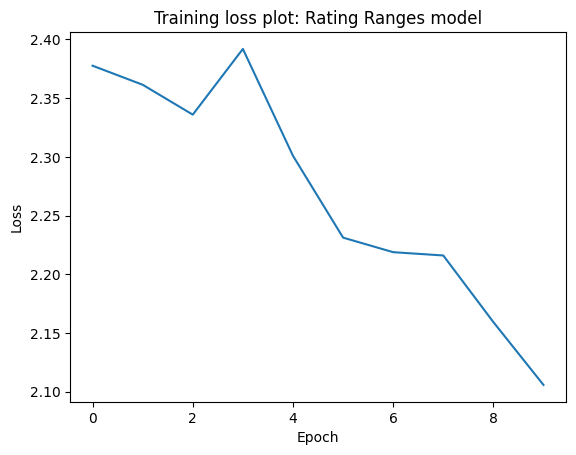

In [13]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
# Should be a downward trend
plt.plot(loss_graph)
plt.title("Training loss plot: Rating Ranges model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# With 10 classes a radnom model would have -log(1/10) = 2.3 loss

### Test how the model predicts new data

The predictions of the model are compared to a random guessing and a constant guessing model

In [14]:
total_loss = 0

predictions = []
real_values = []
c = 0

for x, y in zip(x_test, y_test):
    # Predict for white and black
    out = lstm_model(x[0], train=False)[0] # [0] because model returns (output, (hidden_state, cell_state))
    loss = loss_func(out, y[0].unsqueeze(0)) # unsqueeze because loss function expects a batch
    total_loss += loss.item()
    
    predictions.append(guess_elo_range(out[0])) # [0] because out is a batch
    real_values.append(guess_elo_range(y[0]))
    
    # If the model gave the correct range the maximum probability we can count it as a correct guess
    if (out[0].argmax() == y[0].argmax()): 
        c += 1

    out = lstm_model(x[1], train=False)[0]
    loss = loss_func(out, y[1].unsqueeze(0))
    total_loss += loss.item()
    
    predictions.append(guess_elo_range(out[0]))
    real_values.append(guess_elo_range(y[1]))

    if out[0].argmax() == y[1].argmax():
        c += 1
    
print(f"Average Loss: {total_loss / (len(x_test) * 2)}") # Should ideally be less than 2.3
print(f"Correct range guesses: {c} / {len(x_test) * 2} = {c / (len(x_test) * 2):.2f}")

Average Loss: 2.2680787180708144
Correct range guesses: 99 / 600 = 0.17


In [20]:
def rate_predictions(predictions, real_values):
    correct = 0
    diff = 0
    high_elo = [0, 0]
    low_elo = [0, 0]
    real_high = 0
    real_low = 0
    # We give the model a leeway of +-200 points
    # More leeway = more accuracy
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
        diff += abs(prediction - real)
        if real > 1700:
            high_elo[0] += 1
            high_elo[1] += prediction
            real_high += real
        if real <= 1700:
            low_elo[0] += 1
            low_elo[1] += prediction
            real_low += real
    return correct / len(predictions), correct, diff/len(predictions), high_elo[1]/high_elo[0], low_elo[1]/low_elo[0], real_high/high_elo[0], real_low/low_elo[0]

percentage, correct, diff, high_predictions, low_predictions, real_high, real_low = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")
print(f"Average prediction for high elo games: {high_predictions:.2f} elo. Real average: {real_high:.2f} elo")
print(f"Average prediction for low elo games: {low_predictions:.2f} elo. Real average: {real_low:.2f} elo")


Correctly predicted 35.17% of games
211 out of 600 predictions
Average difference: 380.40 elo
Average prediction for high elo games: 1992.18 elo. Real average: 2220.24 elo
Average prediction for low elo games: 1588.35 elo. Real average: 1205.28 elo


In [28]:
# Compare the model to a random guess. Random values for each rating range
import random

random_predictions = [guess_elo_range([random.random() for _ in range(classes)]) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(random_predictions)} predictions") 
print(f"Average difference: {diff:.2f} elo")  

Correctly guessed at random 20.83% of games
125 out of 600 predictions
Average difference: 519.70 elo


In [24]:
# Compare the model to a constant guess. Equal probability for each rating range
# Outputs a guess somewhere in the middle

constant_predictions = [guess_elo_range([1/classes for _ in range(classes)]) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(constant_predictions, real_values)
print(f"Correctly guessed with constant guess {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(constant_predictions)} predictions")  
print(f"Average difference: {diff:.2f} elo") 

Correctly guessed with constant guess 19.33% of games
116 out of 600 predictions
Average difference: 507.05 elo


In [19]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), "lstm_model_rating_ranges.pt")